# Book Recommendation using TensorFlow Recommenders
This notebook will demonstrate creating a Model for book recommendations using TensorFlow Recommenders with the [basic retriavel](https://www.tensorflow.org/recommenders/examples/basic_retrieval) method. We modified it to be able to recommend several books with 1 book title input.


Retrieval models are often composed of two sub-models:

1. A query model computing the query representation (normally a fixed-dimensionality embedding vector) using query features.
2. A candidate model computing the candidate representation (an equally-sized vector) using the candidate features

The outputs of the two models are then multiplied together to give a query-candidate affinity score, with higher scores expressing a better match between the candidate and the query. 
everyone who gives that rating also means that person reads the book. Every book a user read is a positive example, and every book they have not read is an implicit negative example. 



# Data Preparation

---
---

- Visit https://www.kaggle.com/datasets/zygmunt/goodbooks-10k
- Click download button in the top right corner and the dataset will be downloaded in the form of a zip file
- Find downloaded dataset and extract that file, there are several files, we just need books.csv and ratings.csv.
- Open google drive and create a folder with the name "Dataset" and upload both files there.

## import libraries

In [1]:
%pip install -q tensorflow-recommenders

     |████████████████████████████████| 85 kB 2.9 MB/s 


In [2]:
from typing import Dict, Text

import numpy as np
import pandas as pd
import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

## import libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## read files

In [4]:
df_users = pd.read_csv(
    "./drive/MyDrive/Dataset/ratings.csv"
)
df_users.head(2)

,book_id,user_id,rating
0,1,314,5
1,1,439,3


In [5]:
df_users.shape

(981756, 3)

In [6]:
df_books = pd.read_csv(
    "./drive/MyDrive/Dataset/books.csv"
)
df_books.head(2)

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...


In [7]:
df_books.shape

(10000, 23)

Merge the book dataframe to the user dataframe to retrieve the title.

In [8]:
df_merged = df_users.merge(df_books, on="book_id")
df_merged.tail(2)

,book_id,user_id,rating,id,best_book_id,work_id,books_count,isbn,isbn13,authors,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
79699,9998,52330,4,8114,9998,58336,90,679733787,9.780680e+12,"Kōbō Abe, E. Dale Saunders",...,11467,13886,1026,264,838,3046,5523,4215,https://images.gr-assets.com/books/1361254930m...,https://images.gr-assets.com/books/1361254930s...
79700,9998,53249,5,8114,9998,58336,90,679733787,9.780680e+12,"Kōbō Abe, E. Dale Saunders",...,11467,13886,1026,264,838,3046,5523,4215,https://images.gr-assets.com/books/1361254930m...,https://images.gr-assets.com/books/1361254930s...


In [9]:
df_merged.drop(df_merged.iloc[:, 3:11], inplace = True, axis = 1)
df_merged.drop(df_merged.iloc[:, 4:], inplace = True, axis = 1)
df_merged.tail(2)

,book_id,user_id,rating,original_title
79699,9998,52330,4,砂の女 [Suna no onna]
79700,9998,53249,5,砂の女 [Suna no onna]


# create dataset objects

### create ratings dataset from df_merged

Currently, the type of df_merged.user_id is int. To avoid error, we have to convert int to string.

In [10]:
df_merged.dtypes

book_id            int64
user_id            int64
rating             int64
original_title    object
dtype: object

In [11]:
df_merged.user_id = df_merged.user_id.astype(str)
df_merged.original_title = df_merged.original_title.astype(str)
df_merged.head(2)

,book_id,user_id,rating,original_title
0,1,314,5,Harry Potter and the Half-Blood Prince
1,1,439,3,Harry Potter and the Half-Blood Prince


In [12]:
df_merged.dtypes

book_id            int64
user_id           object
rating             int64
original_title    object
dtype: object

We use tf.data.Dataset.from_tensor_slices. We use df.to_dict('list') to convert the dataframe into a dictionary of (column_name, list_of_values)

In [13]:
users = tf.data.Dataset.from_tensor_slices({
    "user_id": df_merged.user_id.tolist(),
    "original_title": df_merged.original_title.tolist()
})

In [14]:
list(users.take(2).as_numpy_iterator())

[{'original_title': b'Harry Potter and the Half-Blood Prince',
  'user_id': b'314'},
 {'original_title': b'Harry Potter and the Half-Blood Prince',
  'user_id': b'439'}]

Mapping data which will be used for embedding

In [15]:
users = users.map(lambda x: {
    "user_id": x["user_id"],
    "original_title": x["original_title"]
})
list(users.take(2).as_numpy_iterator())

[{'original_title': b'Harry Potter and the Half-Blood Prince',
  'user_id': b'314'},
 {'original_title': b'Harry Potter and the Half-Blood Prince',
  'user_id': b'439'}]

### books dataset

Do the same for book data

In [16]:
df_books.original_title = df_books.original_title.astype(str)
books = tf.data.Dataset.from_tensor_slices({
    "original_title": df_books.original_title.tolist()
})

In [17]:
list(books.take(2).as_numpy_iterator())

[{'original_title': b'The Hunger Games'},
 {'original_title': b"Harry Potter and the Philosopher's Stone"}]

In [18]:
books = books.map(lambda x: x["original_title"])
list(books.take(2).as_numpy_iterator())

[b'The Hunger Games', b"Harry Potter and the Philosopher's Stone"]


books dasaset needs to be unique. 

In [19]:
books = books.unique()
list(books.take(2).as_numpy_iterator())

[b'The Hunger Games', b"Harry Potter and the Philosopher's Stone"]

# Define our model

## get unique user_ids and book_titles

This is important because we need to be able to map the raw values ​​of our categorical features to embed vectors in our model. To do that, we need a vocabulary that maps raw feature values ​​to integers in a contiguous range: this allows us to search for the appropriate embedding in our embedding table.

In [26]:
user_ids = users.batch(1_000_000).map(lambda x: x["user_id"])
book_titles = books.batch(1_000)

unique_user_ids = np.unique(np.concatenate(list(user_ids)))
unique_book_titles = np.unique(np.concatenate(list(book_titles)))

Since we are building a two-tower capture model, we can build each tower separately and then combine them in the final.

In [27]:
class BookLensModel(tfrs.Model):
  #We used the embedding dimension of 16 which is the best so far.
    def __init__(self, embedding_dimension=16):
        super().__init__()
  #In query tower.
  #We use Keras preprocessing layers to convert user id  and then convert those to user embeddings via an Embedding layer.
  #we use the list of unique user ids we computed earlier as a vocabulary.
        self.user_model = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids)+1, embedding_dimension)
        ])
  #We can do the same with the candidate tower.
        self.book_model= tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=unique_book_titles, mask_token=None),
            tf.keras.layers.Embedding(len(unique_book_titles)+1, embedding_dimension)
        ])
  #In our training data we have positive pairs (users, books). To find out how good our model is, 
  #we need to compare the model's calculated affinity score for this pair with the scores of all the other possible candidates.
  #use of the Retrieval task object: a convenience wrapper that bundles together the loss function and metric computation
  #The task itself is a Keras layer that takes the query and candidate embeddings as arguments, and returns the computed loss: we'll use that to implement the model's training loop.
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=books.batch(128).map(self.book_model)
            )
        )
  #implement the compute_loss method, taking in the raw features and returning a loss value.
    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        book_embeddings = self.book_model(features["original_title"])

        return self.task(user_embeddings, book_embeddings)

Instantiate the model and define the compile attribute.


In [28]:
model = BookLensModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# train our model

In the case of image classification, we usually train the model with most of the data and validate/test it with a small amount of data or commonly known as unseen data. Validate/test with unseen data because later the model will predict images from users which of course are not in the train data.

However, it is different in terms of recommendations, the data that will be predicted by the model is the data in the dataset. In our case, the book data that will be displayed in the application comes from the dataset used to create the model, so later the input that the user enters and what the model will process is the data in the dataset. So it would be better if we train the model with all the data in the dataset, this will make better predictions because the model predicts the previously seen data (seen data). It's also less useful to validate/test the model with unseen data, because user input will not be outside the dataset. And according to the source mentioned at the top of the page, there is only train and test(evaluate). Therefore, we will test(evaluate) with the seen data, just to make sure that the model will predict user input with such accuracy.

In [29]:
tf.random.set_seed(42)
shuffled = users.shuffle(10000, seed=42, reshuffle_each_iteration=False)
shuffledtest = shuffled.shuffle(2000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(10000)
test = shuffledtest.take(2000)

In [30]:

cached_train = train.batch(4046).cache()
cached_test = test.batch(4046).cache()

In [31]:
hist = model.fit(cached_train, epochs=200)

Epoch 1/200
3/3 [==============================] - 8s 2s/step - factorized_top_k/top_1_categorical_accuracy: 1.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0045 - factorized_top_k/top_10_categorical_accuracy: 0.0121 - factorized_top_k/top_50_categorical_accuracy: 0.0361 - factorized_top_k/top_100_categorical_accuracy: 0.0523 - loss: 24007.9580 - regularization_loss: 0.0000e+00 - total_loss: 24007.9580
Epoch 2/200
3/3 [==============================] - 6s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0413 - factorized_top_k/top_10_categorical_accuracy: 0.1000 - factorized_top_k/top_50_categorical_accuracy: 0.5274 - factorized_top_k/top_100_categorical_accuracy: 0.6090 - loss: 23915.1865 - regularization_loss: 0.0000e+00 - total_loss: 23915.1865
Epoch 3/200
3/3 [==============================] - 6s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accurac

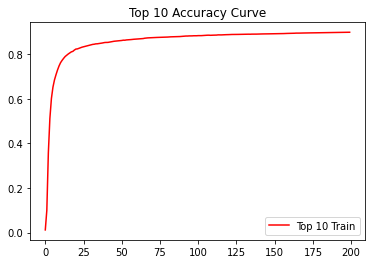

In [32]:
import matplotlib.pyplot as plt
top10train = hist.history['factorized_top_k/top_10_categorical_accuracy']
plt.plot(top10train, color='r', label='Top 10 Train')

plt.title("Top 10 Accuracy Curve")
plt.legend()
plt.show()

In [33]:
hist2 =  model.evaluate(cached_test, return_dict=True)

1/1 [==============================] - 2s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.1690 - factorized_top_k/top_5_categorical_accuracy: 0.7155 - factorized_top_k/top_10_categorical_accuracy: 0.8795 - factorized_top_k/top_50_categorical_accuracy: 0.9975 - factorized_top_k/top_100_categorical_accuracy: 0.9995 - loss: 9057.4453 - regularization_loss: 0.0000e+00 - total_loss: 9057.4453


In train model we get top_10_categorical_accuracy: 0.8986, and in evaluate model we get top_10_categorical_accuracy: 0.8795.

# It's time for recommendation!

Now that we have a model, we want to be able to make predictions. We can use the tfrs.layers.factorized_top_k.BruteForce layer to do this.

In [34]:
index = tfrs.layers.factorized_top_k.BruteForce(model.book_model)
index.index_from_dataset(
  tf.data.Dataset.zip((books.batch(100), books.batch(100).map(model.book_model)))
)

input = "Harry Potter and the Philosopher's Stone"

score, titles = index(tf.constant([input]))
print(f"Recommendations from {input} :")
result_book=titles[0, :10].numpy().tolist()
result_score=score[0, :10].numpy().tolist()
for i in range(len(result_book)):
  print(result_book[i].decode())
  print(" score :"+str(result_score[i]))

Recommendations from Harry Potter and the Philosopher's Stone :
Harry Potter and the Philosopher's Stone
 score :24.923816680908203
Harry Potter and the Half-Blood Prince
 score :20.211181640625
Harry Potter Collection (Harry Potter, #1-6)
 score :19.695627212524414
Harry Potter and the Prisoner of Azkaban
 score :19.657434463500977
The Hitchhiker's Guide to the Galaxy
 score :18.516090393066406
Notes from a Small Island
 score :18.170305252075195
The Lord of the Rings
 score :17.936767578125
The Lord of the Rings: Weapons and Warfare
 score :17.43825912475586
Harry Potter and the Order of the Phoenix
 score :17.067462921142578
Heidi
 score :16.885114669799805


In [35]:
input = "Batman, Volume 3: Death of the Family"

score, titles = index(tf.constant([input]))
print(f"Recommendations from {input} :")
result_book=titles[0, :10].numpy().tolist()
for i in range(len(result_book)):
  print(result_book[i].decode())

Recommendations from Batman, Volume 3: Death of the Family :
Cien años de soledad
The Salmon of Doubt: Hitchhiking the Galaxy One Last Time
The Elegant Universe: Superstrings, Hidden Dimensions, and the Quest for the Ultimate Theory
Sailing Alone Around the Room: New and Selected Poems
The Life and Adventures of Martin Chuzzlewit
The Time Machine
The Tipping Point: How Little Things Can Make a Big Difference
The War of Art: Break Through the Blocks and Win Your Inner Creative Battles
Children of Dune
The Men Who Stare at Goats


In [36]:
input = "The Hunger Game"

score, titles = index(tf.constant([input]))
print(f"Recommendations from {input} :")
result_book=titles[0, :10].numpy().tolist()
for i in range(len(result_book)):
  print(result_book[i].decode())

Recommendations from The Hunger Game :
The Brooklyn Follies
 The Fellowship of the Ring
O Alquimista
Truman
Quicksilver
To Kill a Mockingbird
Pompeii
Todos os Nomes
The Psychology of Everyday Things
Job: A Comedy of Justice


---

# Save Model

In [37]:
import os
import pathlib


Save model to saved_model.pb

In [38]:
curr = os.getcwd()

path = os.path.join(curr, "model")

tf.saved_model.save(index, path)

INFO:tensorflow:Assets written to: /content/model/assets


INFO:tensorflow:Assets written to: /content/model/assets


# Convert to Tflite

Chose optimize, convert to tflite, and save in model.tflite

In [39]:
mode = "Speed" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [40]:
converter = tf.lite.TFLiteConverter.from_saved_model(path)

converter.optimizations =[optimization] 

tflite_model = converter.convert()

In [41]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

886368

In [44]:
from google.colab import files
#download saved_model and other file in folder model
!zip -r /content/modeldownload.zip /content/model
files.download('/content/modeldownload.zip')

updating: content/model/ (stored 0%)
updating: content/model/variables/ (stored 0%)
updating: content/model/variables/variables.data-00000-of-00001 (deflated 15%)
updating: content/model/variables/variables.index (deflated 33%)
updating: content/model/assets/ (stored 0%)
updating: content/model/saved_model.pb (deflated 66%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
#download tflite
files.download('/content/model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>